# UFC Fight Prediction Model

In [1356]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Loading

In [1357]:
master_data = pd.read_csv("ufc_master_dataset.csv")

In [1358]:
# Reorder columns into a logical order
master_data = master_data[[
    # Fight metadata
    "RedFighter", "BlueFighter", "Date", "Location", "Country", "Gender", "TitleBout", "WeightClass", "NumberOfRounds", "EmptyArena",
    
    # Fighter stats
    "RedWins", "BlueWins", "RedLosses", "BlueLosses", "RedDraws", "BlueDraws",
    "RedCurrentWinStreak", "BlueCurrentWinStreak", "RedCurrentLoseStreak", "BlueCurrentLoseStreak",
    "RedLongestWinStreak", "BlueLongestWinStreak",
    "RedTotalRoundsFought", "BlueTotalRoundsFought",
    "RedTotalTitleBouts", "BlueTotalTitleBouts",

    "RedWinsByDecisionUnanimous", "BlueWinsByDecisionUnanimous",
    "RedWinsByDecisionMajority", "BlueWinsByDecisionMajority",
    "RedWinsByDecisionSplit", "BlueWinsByDecisionSplit",
    "RedWinsByKO", "BlueWinsByKO",
    "RedWinsByTKODoctorStoppage", "BlueWinsByTKODoctorStoppage",
    "RedWinsBySubmission", "BlueWinsBySubmission",

    "RedAvgSigStrLanded", "BlueAvgSigStrLanded",
    "RedAvgSigStrPct", "BlueAvgSigStrPct",
    "RedAvgSubAtt", "BlueAvgSubAtt",
    "RedAvgTDLanded", "BlueAvgTDLanded",
    "RedAvgTDPct", "BlueAvgTDPct",

    "RedStance", "BlueStance",
    "RedAge", "BlueAge",
    "RedHeightCms", "BlueHeightCms",
    "RedReachCms", "BlueReachCms",
    "RedWeightLbs", "BlueWeightLbs",

    # Fighter rankings
    "RMatchWCRank", "BMatchWCRank", "RPFPRank", "BPFPRank",
    "RFlyweightRank", "BFlyweightRank", "RBantamweightRank", "BBantamweightRank",
    "RFeatherweightRank", "BFeatherweightRank", "RLightweightRank", "BLightweightRank",
    "RWelterweightRank", "BWelterweightRank", "RMiddleweightRank", "BMiddleweightRank",
    "RLightHeavyweightRank", "BLightHeavyweightRank", "RHeavyweightRank", "BHeavyweightRank",
    "RWFlyweightRank", "BWFlyweightRank", "RWFeatherweightRank", "BWFeatherweightRank",
    "RWStrawweightRank", "BWStrawweightRank", "RWBantamweightRank", "BWBantamweightRank",

    # Differentials
    "WinDif", "LossDif", "WinStreakDif", "LoseStreakDif", "LongestWinStreakDif", "TotalRoundDif", "TotalTitleBoutDif",
    "KODif", "SigStrDif", "SubDif", "AvgSubAttDif",  "AvgTDDif",
    "HeightDif", "ReachDif", "AgeDif",
    "BetterRank",

    # Odds
    "RedOdds", "BlueOdds", "RedExpectedValue", "BlueExpectedValue",
    "RedDecOdds", "BlueDecOdds", "RSubOdds", "BSubOdds", "RKOOdds", "BKOOdds",

    # Fight outcomes
    "Winner", "Finish", "FinishDetails", "FinishRound", "FinishRoundTime", "TotalFightTimeSecs"
]]

## Data Exploration

In [1359]:
master_data

,RedFighter,BlueFighter,Date,Location,Country,Gender,TitleBout,WeightClass,NumberOfRounds,EmptyArena,RedWins,BlueWins,RedLosses,BlueLosses,RedDraws,BlueDraws,RedCurrentWinStreak,BlueCurrentWinStreak,RedCurrentLoseStreak,BlueCurrentLoseStreak,RedLongestWinStreak,BlueLongestWinStreak,RedTotalRoundsFought,BlueTotalRoundsFought,RedTotalTitleBouts,BlueTotalTitleBouts,RedWinsByDecisionUnanimous,BlueWinsByDecisionUnanimous,RedWinsByDecisionMajority,BlueWinsByDecisionMajority,RedWinsByDecisionSplit,BlueWinsByDecisionSplit,RedWinsByKO,BlueWinsByKO,RedWinsByTKODoctorStoppage,BlueWinsByTKODoctorStoppage,RedWinsBySubmission,BlueWinsBySubmission,RedAvgSigStrLanded,BlueAvgSigStrLanded,...,RWFlyweightRank,BWFlyweightRank,RWFeatherweightRank,BWFeatherweightRank,RWStrawweightRank,BWStrawweightRank,RWBantamweightRank,BWBantamweightRank,WinDif,LossDif,WinStreakDif,LoseStreakDif,LongestWinStreakDif,TotalRoundDif,TotalTitleBoutDif,KODif,SigStrDif,SubDif,AvgSubAttDif,AvgTDDif,HeightDif,ReachDif,AgeDif,BetterRank,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,Finish,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs
0,Alexandre Pantoja,Kai Asakura,2024-12-07,"Las Vegas, Nevada, USA",USA,MALE,True,Flyweight,5,NaN,12,0,3,0,0,0,6,0,0,0,6,0,42,0,3,0,4,0,0,0,2,0,2,0,0,0,4,0,4.4100,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12,-3,-6,0,-6,-42,-3,-2,-4.4100,-4,-0.8000,-2.6100,7.62,5.08,-3,Red,-250.0,215.0,40.0000,215.0,300.0,800.0,150.0,2500.0,400.0,350.0,Red,SUB,Rear Naked Choke,2.0,2:05,425.0
1,Shavkat Rakhmonov,Ian Machado Garry,2024-12-07,"Las Vegas, Nevada, USA",USA,MALE,False,Welterweight,3,NaN,6,8,0,0,0,0,6,8,0,0,6,8,11,20,0,0,0,4,0,0,0,1,1,3,0,0,5,0,4.1200,5.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2,0,2,9,0,2,1.3800,-5,-1.5000,-0.7200,5.08,-7.62,-3,Red,-210.0,295.0,47.6190,295.0,250.0,650.0,180.0,3000.0,240.0,700.0,Red,U-DEC,NaN,5.0,5:00,1500.0
2,Ciryl Gane,Alexander Volkov,2024-12-07,"Las Vegas, Nevada, USA",USA,MALE,False,Heavyweight,3,NaN,9,12,2,4,0,0,1,4,0,0,7,4,33,44,3,0,3,4,0,0,0,1,4,6,0,0,2,1,5.4900,5.1300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3,0,-3,11,-3,2,-0.3600,-1,-0.3000,-0.1300,7.62,-2.54,2,Red,-380.0,300.0,26.3158,300.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0,Red,S-DEC,NaN,3.0,5:00,900.0
3,Bryce Mitchell,Kron Gracie,2024-12-07,"Las Vegas, Nevada, USA",USA,MALE,False,Featherweight,3,NaN,7,1,2,2,0,0,0,0,1,2,6,1,22,7,0,0,5,0,1,0,0,0,0,0,0,0,1,1,2.3000,3.7400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6,0,0,1,-5,-15,0,0,1.4400,0,-1.1000,-2.9800,-2.54,0.00,6,Red,-950.0,625.0,10.5263,625.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0,Red,KO/TKO,Elbows,3.0,0:39,639.0
4,Nate Landwehr,Dooho Choi,2024-12-07,"Las Vegas, Nevada, USA",USA,MALE,False,Featherweight,3,NaN,5,4,3,3,0,1,1,1,0,0,3,3,17,15,0,0,1,0,1,0,0,0,1,4,0,0,2,0,6.2500,4.4100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,0,0,0,-2,0,3,-1.8400,-2,-0.2000,-0.2500,2.54,-5.08,-3,neither,-130.0,110.0,76.9231,110.0,275.0,550.0,500.0,700.0,300.0,250.0,Blue,KO/TKO,Elbows,3.0,3:21,801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,Duane Ludwig,Darren Elkins,2010-03-21,"Broomfield, Colorado, USA",USA,MALE,False,Lightweight,3,0.0,2,0,1,0,0,0,0,0,1,0,2,0,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,13.6667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,1,0,1,-2,-5,0,-1,-13.6667,0,0.0000,0.0000,0.00,2.54,6,neither,-155.0,135.0,64.5161,135.0,NaN,NaN,NaN,NaN,NaN,NaN,Blue,KO/TKO,NaN,1.0,0:44,44.0
6524,John Howard,Daniel Roberts,2010-03-21,"Broomfield, Colorado, USA",USA,MALE,False,Welterweight,3,0.0,3,0,0,0,0,0,3,0,0,0,3,0,9,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,18.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3,0,-3,0,-3,-9,0,-1,-18.0000,0,-1.0000,-4.6667,7.62,7.62,-2,nei

In [1360]:
master_data.shape

(6528, 118)

In [1361]:
master_data.describe()

,NumberOfRounds,EmptyArena,RedWins,BlueWins,RedLosses,BlueLosses,RedDraws,BlueDraws,RedCurrentWinStreak,BlueCurrentWinStreak,RedCurrentLoseStreak,BlueCurrentLoseStreak,RedLongestWinStreak,BlueLongestWinStreak,RedTotalRoundsFought,BlueTotalRoundsFought,RedTotalTitleBouts,BlueTotalTitleBouts,RedWinsByDecisionUnanimous,BlueWinsByDecisionUnanimous,RedWinsByDecisionMajority,BlueWinsByDecisionMajority,RedWinsByDecisionSplit,BlueWinsByDecisionSplit,RedWinsByKO,BlueWinsByKO,RedWinsByTKODoctorStoppage,BlueWinsByTKODoctorStoppage,RedWinsBySubmission,BlueWinsBySubmission,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,RedAvgSubAtt,BlueAvgSubAtt,RedAvgTDLanded,BlueAvgTDLanded,RedAvgTDPct,BlueAvgTDPct,...,BMiddleweightRank,RLightHeavyweightRank,BLightHeavyweightRank,RHeavyweightRank,BHeavyweightRank,RWFlyweightRank,BWFlyweightRank,RWFeatherweightRank,BWFeatherweightRank,RWStrawweightRank,BWStrawweightRank,RWBantamweightRank,BWBantamweightRank,WinDif,LossDif,WinStreakDif,LoseStreakDif,LongestWinStreakDif,TotalRoundDif,TotalTitleBoutDif,KODif,SigStrDif,SubDif,AvgSubAttDif,AvgTDDif,HeightDif,ReachDif,AgeDif,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,FinishRound,TotalFightTimeSecs
count,6528.000000,5042.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6073.000000,5598.000000,6171.000000,5763.000000,6171.000000,5696.000000,6171.000000,5695.000000,6161.000000,5686.000000,...,137.000000,184.000000,120.000000,186.000000,148.000000,96.000000,73.000000,9.0,1.0,146.000000,100.000000,154.000000,107.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6301.000000,6302.000000,6301.000000,6302.000000,5441.000000,5412.000000,5192.000000,5169.000000,5194.000000,5168.000000,5906.000000,5906.000000
mean,3.185509,0.153114,4.628064,3.145680,2.566789,1.863664,0.031097,0.023131,1.101562,0.957567,0.622243,0.501072,2.679994,1.923407,17.408548,11.872396,0.553462,0.251685,1.612286,1.093597,0.026961,0.017770,0.400888,0.279871,1.563879,1.066330,0.035539,0.022212,0.934589,0.626532,21.152766,19.841810,0.460321,0.453059,0.536907,0.500202,1.399962,1.320536,0.341467,0.325419,...,8.554745,7.119565,8.483333,6.881720,8.641892,7.291667,8.410959,0.0,0.0,7.047945,8.170000,7.097403,8.476636,-1.482384,0.075061,-0.143842,0.059283,-0.756587,-5.536152,-0.301777,-0.510876,-2.663342,-0.308058,-0.071094,-0.171371,-0.006679,-0.299271,0.096814,-115.711474,59.793240,96.658224,165.054566,308.333395,425.870288,884.048151,1100.497775,510.891606,636.463235,2.424145,657.536234
std,0.577441,0.360133,4.505498,3.712852,2.703546,2.170130,0.187999,0.156327,1.760767,1.406786,0.872301,0.794303,2.242687,1.949952,17.846748,13.845139,1.544962,1.085122,1.972295,1.613288,0.163862,0.133278,0.702801,0.595123,2.156770,1.723951,0.199492,0.153494,1.608402,1.258249,19.882916,20.315307,0.098315,0.110787,0.693125,0.672859,1.308340,1.356491,0.220986,0.239174,...,4.311271,4.638500,4.152519,4.404787,4.090823,4.975554,4.009834,0.0,NaN,4.616809,4.192478,4.803008,4.254511,4.182192,3.129140,1.874732,1.024000,2.025886,17.995648,1.681080,2.149365,19.583493,1.844810,0.892257,1.754354,6.770956,9.132413,5.201719,277.225783,253.117416,85.891109,137.689177,250.750088,325.940028,601.826547,671.106177,426.563458,465.014634,1.007887,360.383418
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [1362]:
master_data.describe(include="object")

,RedFighter,BlueFighter,Date,Location,Country,Gender,WeightClass,RedStance,BlueStance,BetterRank,Winner,Finish,FinishDetails,FinishRoundTime
count,6528,6528,6528,6528,6528,6528,6528,6528,6525,6528,6528,6290,2892,5906
unique,1661,1922,564,150,36,2,13,4,5,3,2,7,39,294
top,Jim Miller,Charles Oliveira,2016-11-19,"Las Vegas, Nevada, USA",USA,MALE,Lightweight,Orthodox,Orthodox,neither,Red,U-DEC,Punch,5:00
freq,29,18,24,2139,2450,5727,1074,4877,4844,4684,3787,2404,677,2956


## Data Preprocessing

In [1363]:
# Add Fight ID
master_data = master_data.reset_index(drop=True)
master_data["FightID"] = master_data.index + 1

# Convert fight date to datetime
master_data["Date"] = pd.to_datetime(master_data["Date"])

# Drop unused columns
master_data = master_data.drop(columns=["Location", "EmptyArena", "FinishRoundTime"])

# Clean string columns
master_data["Country"] = master_data["Country"].str.strip()
master_data["Gender"] = master_data["Gender"].str.strip().str.capitalize()
master_data["WeightClass"] = master_data["WeightClass"].str.replace("Catch Weight", "Catchweight")
master_data["BlueStance"] = master_data["BlueStance"].str.strip()

# Flip sign of differential columns so they represent Red − Blue
dif_cols = [col for col in master_data.columns if col.endswith("Dif")]
master_data[dif_cols] = master_data[dif_cols] * -1

## Feature Engineering

### Date

In [1364]:
# Extract year
master_data["Year"] = master_data["Date"].dt.year

# Build fighter-level history
red_history = master_data[["RedFighter", "Date"]].rename(columns={"RedFighter": "Fighter"})
blue_history = master_data[["BlueFighter", "Date"]].rename(columns={"BlueFighter": "Fighter"})
fighter_history = pd.concat([red_history, blue_history], ignore_index=True)

# Sort and compute days since last fight
fighter_history = (
    fighter_history
    .sort_values(["Fighter", "Date"])
    .assign(DaysSinceLastFight=lambda df: df.groupby("Fighter")["Date"].diff().dt.days)
)

# Merge back to master_data
for color in ["Red", "Blue"]:
    master_data = master_data.merge(
        fighter_history.rename(
            columns={
                "Fighter": f"{color}Fighter",
                "DaysSinceLastFight": f"{color}DaysSinceLastFight"
            }
        ),
        on=[f"{color}Fighter", "Date"],
        how="left"
    )

# Debut flags
master_data["IsRedDebut"] = master_data["RedDaysSinceLastFight"].isna().astype(int)
master_data["IsBlueDebut"] = master_data["BlueDaysSinceLastFight"].isna().astype(int)

### Rank

In [1365]:
def transform_rank(x):
    """
    Transform raw ranking values into a normalized strength score.

    Rules:
    - Missing value → 0 (unranked)
    - 0 → 16 (champion)
    - 1–15 → mapped to 15–1 (so higher = stronger)
    
    This ensures that larger values consistently represent stronger rankings.
    """
    if pd.isna(x):
        return 0
    elif x == 0:
        return 16
    else:
        return 16 - x

In [1366]:
# Identify rank columns
rank_cols = [c for c in master_data.columns if c.endswith("Rank") and c != "BetterRank"]

# Apply transformation
master_data[rank_cols] = master_data[rank_cols].applymap(transform_rank)

# Create differentials for current fight weight class rank and pound-for-pound rank
master_data["MatchWCRankDif"] = master_data["RMatchWCRank"] - master_data["BMatchWCRank"]
master_data["PFPRankDif"] = master_data["RPFPRank"] - master_data["BPFPRank"]

# Red & Blue rank columns (exclude WC/PFP and BetterRank)
rank_cols_red = [c for c in rank_cols if c.startswith("R") and c not in ["RMatchWCRank", "RPFPRank"]]
rank_cols_blue = [c for c in rank_cols if c.startswith("B") and c not in ["BMatchWCRank", "BPFPRank"]]

# Collapse into one strength score per fighter
master_data["RedRankStrength"] = master_data[rank_cols_red].max(axis=1)
master_data["BlueRankStrength"] = master_data[rank_cols_blue].max(axis=1)

# Calculate rank strength differential
master_data["RankStrengthDif"] = master_data["RedRankStrength"] - master_data["BlueRankStrength"]

# Drop raw rank columns
master_data = master_data.drop(columns=rank_cols_red + rank_cols_blue + ["BetterRank"])

### Differentials

In [1367]:
# Combine Red/Blue decision totals
master_data["RedWinsByDecision"] = (
    master_data["RedWinsByDecisionMajority"]
    + master_data["RedWinsByDecisionSplit"]
    + master_data["RedWinsByDecisionUnanimous"]
)

master_data["BlueWinsByDecision"] = (
    master_data["BlueWinsByDecisionMajority"]
    + master_data["BlueWinsByDecisionSplit"]
    + master_data["BlueWinsByDecisionUnanimous"]
)

# Create additional differentials
diff_stats = ["WinsByDecision", "AvgSigStrPct", "AvgTDPct"]

for stat in diff_stats:
    master_data[f"{stat}Dif"] = master_data[f"Red{stat}"] - master_data[f"Blue{stat}"]

# Rename for clarity
master_data = master_data.rename(columns={
    "WinsByDecisionDif": "DecisionDif",
    "AvgSigStrPctDif": "SigStrPctDif",
    "AvgSubAttDif": "SubAttDif",
    "AvgTDDif": "TDDif",
    "AvgTDPctDif": "TDPctDif"
})

# Drop decision total columns since individual decision type totals are already included
master_data = master_data.drop(columns=["RedWinsByDecision", "BlueWinsByDecision"])

### Odds

In [1368]:
def odds_to_prob(odds):
    """
    Convert American odds to implied probability.

    - Negative odds: |odds| / (|odds| + 100)
    - Positive odds: 100 / (odds + 100)
    """
    odds = np.asarray(odds, dtype=float)
    return np.where(odds < 0, np.abs(odds) / (np.abs(odds) + 100), 100 / (odds + 100))


# Apply for Red and Blue
master_data["RedProb"] = odds_to_prob(master_data["RedOdds"])
master_data["BlueProb"] = odds_to_prob(master_data["BlueOdds"])

### Finalize

In [1369]:
# Encode winner: Red = 1, Blue = 0
master_data['Winner'] = [1 if winner == 'Red' else 0 for winner in master_data.Winner]

In [1370]:
# Define column order
col_order = [
    # Fight metadata
    "FightID", "RedFighter", "BlueFighter", "Date", "Year", "Country", "Gender", "TitleBout", "WeightClass", "NumberOfRounds",
    
    # Fighter stats
    "IsRedDebut", "IsBlueDebut", "RedDaysSinceLastFight", "BlueDaysSinceLastFight",
    "RedWins", "BlueWins", "RedLosses", "BlueLosses", "RedDraws", "BlueDraws",
    "RedCurrentWinStreak", "BlueCurrentWinStreak", "RedCurrentLoseStreak", "BlueCurrentLoseStreak",
    "RedLongestWinStreak", "BlueLongestWinStreak",
    "RedTotalRoundsFought", "BlueTotalRoundsFought",
    "RedTotalTitleBouts", "BlueTotalTitleBouts",

    "RedWinsByDecisionUnanimous", "BlueWinsByDecisionUnanimous",
    "RedWinsByDecisionMajority", "BlueWinsByDecisionMajority",
    "RedWinsByDecisionSplit", "BlueWinsByDecisionSplit",
    "RedWinsByKO", "BlueWinsByKO",
    "RedWinsByTKODoctorStoppage", "BlueWinsByTKODoctorStoppage",
    "RedWinsBySubmission", "BlueWinsBySubmission",

    "RedAvgSigStrLanded", "BlueAvgSigStrLanded",
    "RedAvgSigStrPct", "BlueAvgSigStrPct",
    "RedAvgSubAtt", "BlueAvgSubAtt",
    "RedAvgTDLanded", "BlueAvgTDLanded",
    "RedAvgTDPct", "BlueAvgTDPct",

    "RedStance", "BlueStance",
    "RedAge", "BlueAge",
    "RedHeightCms", "BlueHeightCms",
    "RedReachCms", "BlueReachCms",
    "RedWeightLbs", "BlueWeightLbs",

    # Fighter rankings
    "RMatchWCRank", "BMatchWCRank", "RPFPRank", "BPFPRank", "RedRankStrength", "BlueRankStrength",

    # Differentials
    "WinDif", "LossDif", "WinStreakDif", "LoseStreakDif", "LongestWinStreakDif", "TotalRoundDif", "TotalTitleBoutDif",
    "DecisionDif", "KODif", "SigStrDif", "SigStrPctDif", "SubDif", "SubAttDif", "TDDif", "TDPctDif",
    "AgeDif", "HeightDif", "ReachDif",

    # Odds
    "RedOdds", "BlueOdds", "RedProb", "BlueProb", "RedExpectedValue", "BlueExpectedValue",
    "RedDecOdds", "BlueDecOdds", "RSubOdds", "BSubOdds", "RKOOdds", "BKOOdds",

    # Fight outcomes
    "Winner", "Finish", "FinishDetails", "FinishRound", "TotalFightTimeSecs"
]

# Reorder dataset
master_data = master_data[col_order]

In [1371]:
master_data

,FightID,RedFighter,BlueFighter,Date,Year,Country,Gender,TitleBout,WeightClass,NumberOfRounds,IsRedDebut,IsBlueDebut,RedDaysSinceLastFight,BlueDaysSinceLastFight,RedWins,BlueWins,RedLosses,BlueLosses,RedDraws,BlueDraws,RedCurrentWinStreak,BlueCurrentWinStreak,RedCurrentLoseStreak,BlueCurrentLoseStreak,RedLongestWinStreak,BlueLongestWinStreak,RedTotalRoundsFought,BlueTotalRoundsFought,RedTotalTitleBouts,BlueTotalTitleBouts,RedWinsByDecisionUnanimous,BlueWinsByDecisionUnanimous,RedWinsByDecisionMajority,BlueWinsByDecisionMajority,RedWinsByDecisionSplit,BlueWinsByDecisionSplit,RedWinsByKO,BlueWinsByKO,RedWinsByTKODoctorStoppage,BlueWinsByTKODoctorStoppage,...,BMatchWCRank,RPFPRank,BPFPRank,RedRankStrength,BlueRankStrength,WinDif,LossDif,WinStreakDif,LoseStreakDif,LongestWinStreakDif,TotalRoundDif,TotalTitleBoutDif,DecisionDif,KODif,SigStrDif,SigStrPctDif,SubDif,SubAttDif,TDDif,TDPctDif,AgeDif,HeightDif,ReachDif,RedOdds,BlueOdds,RedProb,BlueProb,RedExpectedValue,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,Finish,FinishDetails,FinishRound,TotalFightTimeSecs
0,1,Alexandre Pantoja,Kai Asakura,2024-12-07,2024,USA,Male,True,Flyweight,5,0,1,217.0,NaN,12,0,3,0,0,0,6,0,0,0,6,0,42,0,3,0,4,0,0,0,2,0,2,0,0,0,...,0.0,5.0,0.0,16.0,0.0,12,3,6,0,6,42,3,6,2,4.4100,0.490,4,0.8000,2.6100,0.470,3,-7.62,-5.08,-250.0,215.0,0.714286,0.317460,40.0000,215.0,300.0,800.0,150.0,2500.0,400.0,350.0,1,SUB,Rear Naked Choke,2.0,425.0
1,2,Shavkat Rakhmonov,Ian Machado Garry,2024-12-07,2024,USA,Male,False,Welterweight,3,0,0,357.0,161.0,6,8,0,0,0,0,6,8,0,0,6,8,11,20,0,0,0,4,0,0,0,1,1,3,0,0,...,9.0,0.0,0.0,13.0,9.0,-2,0,-2,0,-2,-9,0,-5,-2,-1.3800,0.060,5,1.5000,0.7200,-0.260,3,-5.08,7.62,-210.0,295.0,0.677419,0.253165,47.6190,295.0,250.0,650.0,180.0,3000.0,240.0,700.0,1,U-DEC,NaN,5.0,1500.0
2,3,Ciryl Gane,Alexander Volkov,2024-12-07,2024,USA,Male,False,Heavyweight,3,0,0,462.0,168.0,9,12,2,4,0,0,1,4,0,0,7,4,33,44,3,0,3,4,0,0,0,1,4,6,0,0,...,13.0,0.0,0.0,14.0,13.0,-3,-2,-3,0,3,-11,3,-2,-2,0.3600,0.030,1,0.3000,0.1300,-0.420,-2,-7.62,2.54,-380.0,300.0,0.791667,0.250000,26.3158,300.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0,1,S-DEC,NaN,3.0,900.0
3,4,Bryce Mitchell,Kron Gracie,2024-12-07,2024,USA,Male,False,Featherweight,3,0,0,357.0,581.0,7,1,2,2,0,0,0,0,1,2,6,1,22,7,0,0,5,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,3.0,0.0,6,0,0,-1,5,15,0,6,0,-1.4400,0.140,0,1.1000,2.9800,0.160,-6,2.54,-0.00,-950.0,625.0,0.904762,0.137931,10.5263,625.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0,1,KO/TKO,Elbows,3.0,639.0
4,5,Nate Landwehr,Dooho Choi,2024-12-07,2024,USA,Male,False,Featherweight,3,0,0,252.0,140.0,5,4,3,3,0,1,1,1,0,0,3,3,17,15,0,0,1,0,1,0,0,0,1,4,0,0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,2,0,2,-3,1.8400,-0.070,2,0.2000,0.2500,0.040,3,-2.54,5.08,-130.0,110.0,0.565217,0.476190,76.9231,110.0,275.0,550.0,500.0,700.0,300.0,250.0,0,KO/TKO,Elbows,3.0,801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,6524,Duane Ludwig,Darren Elkins,2010-03-21,2010,USA,Male,False,Lightweight,3,1,1,NaN,NaN,2,0,1,0,0,0,0,0,1,0,2,0,5,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,2,-1,0,-1,2,5,0,1,1,13.6667,NaN,0,-0.0000,-0.0000,NaN,-6,-0.00,-2.54,-155.0,135.0,0.607843,0.425532,64.5161,135.0,NaN,NaN,NaN,NaN,NaN,NaN,0,KO/TKO,NaN,1.0,44.0
6524,6525,John Howard,Daniel Roberts,2010-03-21,2010,USA,Male,False,Welterweight,3,1,1,NaN,NaN,3,0,0,0,0,0,3,0,0,0,3,0,9,0,0,0,0,0,0,0,2,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3,0,3,0,3,9,0,2,1,18.0000,NaN,0,1.0000,4.6667,NaN,2,-7.62,-7.62,-210.0,175.0,0.677419,0.363636,47.6190,175.0,NaN,NaN,NaN,NaN,NaN,NaN,1,KO/TKO,Punch,1.0,121.0
6525,6526,Brendan Schaub,Chase Gormley,2010-03-21,2010,USA,Male,False,Heavyweight,3,1,1,NaN,NaN,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0

In [1372]:
master_data.describe()

,FightID,Date,Year,NumberOfRounds,IsRedDebut,IsBlueDebut,RedDaysSinceLastFight,BlueDaysSinceLastFight,RedWins,BlueWins,RedLosses,BlueLosses,RedDraws,BlueDraws,RedCurrentWinStreak,BlueCurrentWinStreak,RedCurrentLoseStreak,BlueCurrentLoseStreak,RedLongestWinStreak,BlueLongestWinStreak,RedTotalRoundsFought,BlueTotalRoundsFought,RedTotalTitleBouts,BlueTotalTitleBouts,RedWinsByDecisionUnanimous,BlueWinsByDecisionUnanimous,RedWinsByDecisionMajority,BlueWinsByDecisionMajority,RedWinsByDecisionSplit,BlueWinsByDecisionSplit,RedWinsByKO,BlueWinsByKO,RedWinsByTKODoctorStoppage,BlueWinsByTKODoctorStoppage,RedWinsBySubmission,BlueWinsBySubmission,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,...,BlueWeightLbs,RMatchWCRank,BMatchWCRank,RPFPRank,BPFPRank,RedRankStrength,BlueRankStrength,WinDif,LossDif,WinStreakDif,LoseStreakDif,LongestWinStreakDif,TotalRoundDif,TotalTitleBoutDif,DecisionDif,KODif,SigStrDif,SigStrPctDif,SubDif,SubAttDif,TDDif,TDPctDif,AgeDif,HeightDif,ReachDif,RedOdds,BlueOdds,RedProb,BlueProb,RedExpectedValue,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,FinishRound,TotalFightTimeSecs
count,6528.000000,6528,6528.000000,6528.000000,6528.000000,6528.000000,5815.000000,5129.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6073.000000,5598.000000,6171.000000,5763.000000,...,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.00000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,5641.000000,6528.000000,6528.000000,6528.000000,5575.000000,6528.000000,6528.000000,6528.000000,6301.000000,6302.000000,6301.000000,6302.000000,6301.000000,6302.000000,5441.000000,5412.000000,5192.000000,5169.000000,5194.000000,5168.000000,6528.000000,5906.000000,5906.000000
mean,3264.500000,2018-03-19 18:17:12.352941312,2017.699449,3.185509,0.109222,0.214308,216.718143,213.726457,4.628064,3.145680,2.566789,1.863664,0.031097,0.023131,1.101562,0.957567,0.622243,0.501072,2.679994,1.923407,17.408548,11.872396,0.553462,0.251685,1.612286,1.093597,0.026961,0.017770,0.400888,0.279871,1.563879,1.066330,0.035539,0.022212,0.934589,0.626532,21.152766,19.841810,0.460321,0.453059,...,163.183977,2.465380,1.408241,0.352175,0.069853,2.564338,1.51394,1.482384,-0.075061,0.143842,-0.059283,0.756587,5.536152,0.301777,0.648897,0.510876,2.663342,0.008139,0.308058,0.071094,0.171371,0.019948,-0.096814,0.006679,0.299271,-115.711474,59.793240,0.578080,0.456833,96.658224,165.054566,308.333395,425.870288,884.048151,1100.497775,510.891606,636.463235,0.580116,2.424145,657.536234
min,1.000000,2010-03-21 00:00:00,2010.000000,3.000000,0.000000,0.000000,7.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-23.000000,-16.000000,-10.000000,-6.000000,-14.000000,-87.000000,-15.000000,-11.000000,-14.000000,-128.222200,-0.570000,-10.000000,-7.800000,-10.860000,-1.000000,-17.000000,-30.480000,-30.480000,-2100.000000,-1200.000000,0.114286,0.071429,4.761900,8.333300,-440.000000,-200.000000,-370.000000,-1250.000000,-550.000000,-400.000000,0.000000,1.000000,5.000000
25%,1632.750000,2014-11-08 00:00:00,2014.000000,3.000000,0.000000,0.000000,132.000000,120.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [1373]:
master_data.describe(include="object")

,RedFighter,BlueFighter,Country,Gender,WeightClass,RedStance,BlueStance,Finish,FinishDetails
count,6528,6528,6528,6528,6528,6528,6525,6290,2892
unique,1661,1922,27,2,13,4,4,7,39
top,Jim Miller,Charles Oliveira,USA,Male,Lightweight,Orthodox,Orthodox,U-DEC,Punch
freq,29,18,4344,5727,1074,4877,4844,2404,677


## Data Visualization

In [1374]:
# Correlation of numeric features with target
num_corr_cols = master_data.select_dtypes(include=["number"]).columns.drop("Winner")

corr_series = master_data[num_corr_cols].corrwith(master_data["Winner"]).abs()
corr_series = corr_series.sort_values(ascending=False)

# Display
for col, corr in corr_series.round(2).items():
    print(col, corr)

RedProb 0.36
BlueProb 0.36
BlueOdds 0.35
RedOdds 0.34
RedExpectedValue 0.32
BlueExpectedValue 0.32
BlueDecOdds 0.23
BKOOdds 0.21
RKOOdds 0.2
BSubOdds 0.18
RedDecOdds 0.17
RSubOdds 0.16
WinStreakDif 0.12
RedAge 0.12
TDDif 0.11
BlueAge 0.11
SigStrPctDif 0.11
RedLosses 0.1
RedAvgSigStrPct 0.09
RedAvgTDLanded 0.08
RedWinsByDecisionSplit 0.08
BlueAvgTDLanded 0.08
RedCurrentWinStreak 0.07
TDPctDif 0.07
RedCurrentLoseStreak 0.07
BlueCurrentWinStreak 0.07
TotalRoundDif 0.07
RedAvgTDPct 0.07
ReachDif 0.06
BlueAvgSigStrPct 0.06
SubAttDif 0.06
SigStrDif 0.05
RedTotalRoundsFought 0.05
BlueLosses 0.05
RedAvgSubAtt 0.05
KODif 0.05
WinDif 0.04
LongestWinStreakDif 0.04
RPFPRank 0.04
HeightDif 0.04
RedDaysSinceLastFight 0.04
BlueAvgTDPct 0.04
RedRankStrength 0.03
RedWinsByKO 0.03
DecisionDif 0.03
RedWins 0.03
AgeDif 0.03
BlueAvgSubAtt 0.03
RMatchWCRank 0.03
BlueWinsByDecisionSplit 0.03
BlueDraws 0.03
BlueDaysSinceLastFight 0.03
RedAvgSigStrLanded 0.03
BlueCurrentLoseStreak 0.03
BlueAvgSigStrLanded 0.03

In [1375]:
master_data["Winner"].value_counts(normalize=True)

Winner
1    0.580116
0    0.419884
Name: proportion, dtype: float64

In [1376]:
# Favorite fighter based on odds
conditions = [
    master_data["RedOdds"] < master_data["BlueOdds"],
    master_data["BlueOdds"] < master_data["RedOdds"]
]
choices = ["Red", "Blue"]

master_data["Favorite"] = np.select(conditions, choices, default="Pick'em")

# Distribution
master_data["Favorite"].value_counts(normalize=True)

Favorite
Red        0.598652
Blue       0.347273
Pick'em    0.054075
Name: proportion, dtype: float64

In [1377]:
# Drop Favorite
master_data = master_data.drop(columns=["Favorite"])

## Train/Test Split

In [1378]:
drop_cols = [
    "FightID", "RedFighter", "BlueFighter", "Date",
    "RedOdds", "BlueOdds", "RedExpectedValue", "BlueExpectedValue",
    "RedDecOdds", "BlueDecOdds", "RSubOdds", "BSubOdds", "RKOOdds", "BKOOdds",
    "Winner", "Finish", "FinishDetails", "FinishRound", "TotalFightTimeSecs",
]

# Features & target
X = master_data.drop(columns=drop_cols)
y = master_data["Winner"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [1379]:
# Split numeric & categorical columns
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Preprocessing: impute + scale numeric, impute + encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), categorical_cols),
    ]
)

# Pipeline with preprocessing + PCA
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.95, random_state=42))
])

# Fit & transform
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

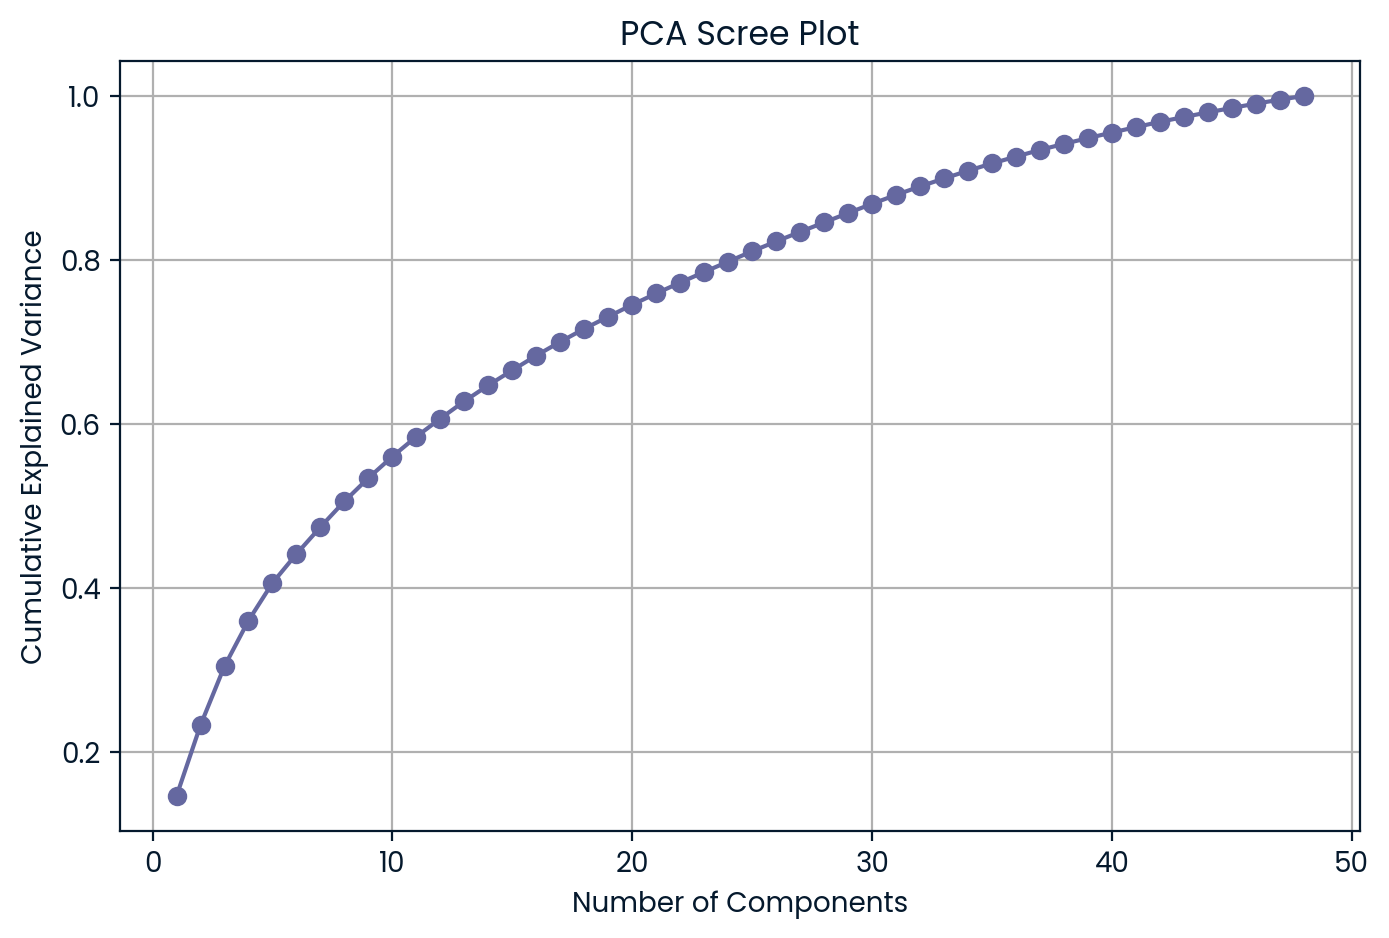

In [1380]:
# Preprocess training data into numeric form
X_train_prepared = X_train

# Fit PCA
pca = PCA().fit(X_train_prepared)

# Cumulative explained variance
explained_var = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

## Model Selection

### Base Model

In [1381]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Cross-validation with 5 folds
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring="accuracy")

print("Mean CV Accuracy:", cv_scores.mean().round(3))
print("Std CV Accuracy:", cv_scores.std().round(3))

Mean CV Accuracy: 0.663
Std CV Accuracy: 0.007


### Multiple Model Run

In [1382]:
# Define models
models = {
    # Linear models
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # Instance-based
    "K-Nearest Neighbors": KNeighborsClassifier(),
    # Margin-based
    "Support Vector Machine": SVC(random_state=42),
    # Trees
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    # Ensembles
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

# Train & evaluate
results = []

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_acc = round(accuracy_score(y_train, y_pred_train), 3)
    test_acc = round(accuracy_score(y_test, y_pred_test), 3)

    results.append((name, train_acc, test_acc))

# Display the results
results = (
    pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy"])
    .sort_values(by="Test Accuracy", ascending=False)
    .reset_index(drop=True)
)

print(results)

                    Model  Train Accuracy  Test Accuracy
0     Logistic Regression           0.670          0.642
1       Gradient Boosting           0.752          0.642
2  Support Vector Machine           0.771          0.638
3           Random Forest           1.000          0.632
4                 XGBoost           1.000          0.618
5     K-Nearest Neighbors           0.742          0.574
6           Decision Tree           1.000          0.557


In [1383]:
# Hyperparameter grid for Logistic Regression
param_grid_logreg = {
    "penalty": ["l1", "l2", "elasticnet", None],   # type of regularization
    "C": [0.01, 0.1, 1, 10, 100],                  # inverse of regularization strength
    "solver": ["lbfgs", "liblinear", "saga"],      # optimization algorithms
    "max_iter": [1000],                            # ensure convergence
    "l1_ratio": [0, 0.5, 1]                        # only used if penalty="elasticnet"
}

# Randomized search
logreg_random = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_grid_logreg,
    n_iter=25,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit search
logreg_random.fit(X_train, y_train)

# Best model
logreg_best_model = logreg_random.best_estimator_

# Evaluate
y_pred_best_logreg = logreg_best_model.predict(X_test)
logreg_random_accuracy = round(accuracy_score(y_test, y_pred_best_logreg), 3)

# Print results
print("Best Parameters:", logreg_random.best_params_)
print("Mean CV Accuracy:", round(logreg_random.best_score_, 3))
print("Test Accuracy:", logreg_random_accuracy)

Best Parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1000, 'l1_ratio': 1, 'C': 0.1}
Mean CV Accuracy: 0.663
Test Accuracy: 0.642


In [1384]:
from sklearn.model_selection import TimeSeriesSplit

# Sort chronologically
temp_data = master_data.sort_values("Date").reset_index(drop=True)

X = temp_data.drop(columns=drop_cols)
y = temp_data["Winner"]

# Walk-forward split
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold_accuracies = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Identify column types for preprocessing
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    # Preprocessing: impute + scale numeric, impute + encode categorical
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler())
            ]), numeric_cols),

            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
            ]), categorical_cols),
        ]
    )

    # Build pipeline: preprocessing → PCA → tuned Logistic Regression
    pipeline_temp = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=0.95, random_state=42)),
        ("model", logreg_best_model)  # best Logistic Regression
    ])

    # Fit pipeline on this fold
    pipeline_temp.fit(X_train, y_train)

    # Predict on this fold’s test set
    y_pred = pipeline_temp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    fold_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.3f}")

print("\nAverage accuracy across folds:", round(sum(fold_accuracies) / len(fold_accuracies), 3))

Fold 1 Accuracy: 0.640
Fold 2 Accuracy: 0.655
Fold 3 Accuracy: 0.644
Fold 4 Accuracy: 0.662
Fold 5 Accuracy: 0.658

Average accuracy across folds: 0.652


## Predictions

In [1385]:
def clean_fight_data(df):
    """
    Clean and preprocess raw UFC fight data.
    Applies feature engineering, transformations, and reordering.
    Returns a cleaned dataframe.
    """

    # Reset index & add FightID
    df = df.reset_index(drop=True)
    df["FightID"] = df.index + 1

    # Convert fight date to datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # Drop unused columns
    df = df.drop(columns=["Location", "EmptyArena", "FinishRoundTime"], errors="ignore")

    # Clean string columns
    df["Country"] = df["Country"].str.strip()
    df["Gender"] = df["Gender"].str.strip().str.capitalize()
    df["WeightClass"] = df["WeightClass"].str.replace("Catch Weight", "Catchweight")
    df["BlueStance"] = df["BlueStance"].str.strip()

    # Flip sign of differential columns so they represent Red − Blue
    dif_cols = [col for col in df.columns if col.endswith("Dif")]
    df[dif_cols] = df[dif_cols] * -1

    # Year
    df["Year"] = df["Date"].dt.year

    # Fighter-level history
    red_history = df[["RedFighter", "Date"]].rename(columns={"RedFighter": "Fighter"})
    blue_history = df[["BlueFighter", "Date"]].rename(columns={"BlueFighter": "Fighter"})
    fighter_history = pd.concat([red_history, blue_history], ignore_index=True)

    fighter_history = (
        fighter_history
        .sort_values(["Fighter", "Date"])
        .assign(DaysSinceLastFight=lambda f: f.groupby("Fighter")["Date"].diff().dt.days)
    )

    for color in ["Red", "Blue"]:
        df = df.merge(
            fighter_history.rename(
                columns={
                    "Fighter": f"{color}Fighter",
                    "DaysSinceLastFight": f"{color}DaysSinceLastFight"
                }
            ),
            on=[f"{color}Fighter", "Date"],
            how="left"
        )

    # Debut flags
    df["IsRedDebut"] = df["RedDaysSinceLastFight"].isna().astype(int)
    df["IsBlueDebut"] = df["BlueDaysSinceLastFight"].isna().astype(int)

    # Ranking transformations
    rank_cols = [c for c in df.columns if c.endswith("Rank") and c != "BetterRank"]
    df[rank_cols] = df[rank_cols].applymap(transform_rank)

    df["MatchWCRankDif"] = df["RMatchWCRank"] - df["BMatchWCRank"]
    df["PFPRankDif"] = df["RPFPRank"] - df["BPFPRank"]

    rank_cols_red = [c for c in rank_cols if c.startswith("R") and c not in ["RMatchWCRank", "RPFPRank"]]
    rank_cols_blue = [c for c in rank_cols if c.startswith("B") and c not in ["BMatchWCRank", "BPFPRank"]]

    df["RedRankStrength"] = df[rank_cols_red].max(axis=1)
    df["BlueRankStrength"] = df[rank_cols_blue].max(axis=1)
    df["RankStrengthDif"] = df["RedRankStrength"] - df["BlueRankStrength"]

    df = df.drop(columns=rank_cols_red + rank_cols_blue + ["BetterRank"], errors="ignore")

    # Combine Red/Blue decision totals
    df["RedWinsByDecision"] = (
        df["RedWinsByDecisionMajority"]
        + df["RedWinsByDecisionSplit"]
        + df["RedWinsByDecisionUnanimous"]
    )
    df["BlueWinsByDecision"] = (
        df["BlueWinsByDecisionMajority"]
        + df["BlueWinsByDecisionSplit"]
        + df["BlueWinsByDecisionUnanimous"]
    )

    # Create additional differentials
    diff_stats = ["WinsByDecision", "AvgSigStrPct", "AvgTDPct"]
    for stat in diff_stats:
        df[f"{stat}Dif"] = df[f"Red{stat}"] - df[f"Blue{stat}"]

    df = df.rename(columns={
        "WinsByDecisionDif": "DecisionDif",
        "AvgSigStrPctDif": "SigStrPctDif",
        "AvgSubAttDif": "SubAttDif",
        "AvgTDDif": "TDDif",
        "AvgTDPctDif": "TDPctDif"
    })

    df = df.drop(columns=["RedWinsByDecision", "BlueWinsByDecision"], errors="ignore")

    # Odds → implied probability
    df["RedProb"] = odds_to_prob(df["RedOdds"])
    df["BlueProb"] = odds_to_prob(df["BlueOdds"])

    # Reorder dataset
    df = df[col_order]

    return df

In [1386]:
validation_data = pd.read_csv("ufc_upcoming_fights.csv")
validation_data

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,TitleBout,WeightClass,Gender,NumberOfRounds,BlueCurrentLoseStreak,BlueCurrentWinStreak,BlueDraws,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueLongestWinStreak,BlueLosses,BlueTotalRoundsFought,BlueTotalTitleBouts,BlueWinsByDecisionMajority,BlueWinsByDecisionSplit,BlueWinsByDecisionUnanimous,BlueWinsByKO,BlueWinsBySubmission,BlueWinsByTKODoctorStoppage,BlueWins,BlueStance,BlueHeightCms,BlueReachCms,BlueWeightLbs,RedCurrentLoseStreak,RedCurrentWinStreak,RedDraws,...,BMatchWCRank,RMatchWCRank,RWFlyweightRank,RWFeatherweightRank,RWStrawweightRank,RWBantamweightRank,RHeavyweightRank,RLightHeavyweightRank,RMiddleweightRank,RWelterweightRank,RLightweightRank,RFeatherweightRank,RBantamweightRank,RFlyweightRank,RPFPRank,BWFlyweightRank,BWFeatherweightRank,BWStrawweightRank,BWBantamweightRank,BHeavyweightRank,BLightHeavyweightRank,BMiddleweightRank,BWelterweightRank,BLightweightRank,BFeatherweightRank,BBantamweightRank,BFlyweightRank,BPFPRank,BetterRank,Finish,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Colby Covington,Joaquin Buckley,205,-250,205.0000,40.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Welterweight,MALE,5,0,5,0,4.13,0.36,0.0,1.96,0.46,5,4,34,0,0,1,2,7,0,0,10,Southpaw,177.80,193.04,170,1,0,0,...,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,300,175.0,1800,2000.0,1100,150.0
1,Cub Swanson,Billy Quarantillo,124,-148,124.0000,67.5676,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Featherweight,MALE,3,1,0,0,7.36,0.56,1.1,1.24,0.23,4,4,28,0,0,0,2,4,1,0,7,Orthodox,177.80,177.80,145,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN,250,NaN,1800,NaN,450,NaN
2,Manel Kape,Bruno Silva,-395,310,25.3165,310.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Flyweight,MALE,3,0,4,0,3.32,0.48,0.2,2.26,0.28,4,2,16,0,0,0,0,3,1,0,4,Orthodox,162.56,165.10,125,1,0,0,...,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,Red,NaN,NaN,NaN,NaN,NaN,-105,550.0,900,1800.0,225,1100.0
3,Vitor Petrino,Dustin Jacoby,-340,270,29.4118,270.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Light Heavyweight,MALE,3,2,0,1,5.50,0.47,0.0,0.36,0.25,4,6,35,0,0,0,4,4,0,0,8,Orthodox,190.50,193.04,205,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN,240,500.0,550,3000.0,110,800.0
4,Adrian Yanez,Daniel Marcos,185,-225,185.0000,44.4444,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Bantamweight,MALE,3,0,4,0,5.94,0.52,0.0,0.25,0.50,4,0,13,0,0,1,2,1,0,0,4,Orthodox,170.18,175.26,135,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN,450,150.0,2200,2200.0,450,200.0
5,Navajo Stirling,Tuco Tokkos,-750,525,13.3333,525.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Light Heavyweight,MALE,3,2,0,0,3.26,0.43,0.0,1.96,1.00,0,2,2,0,0,0,0,0,0,0,0,Orthodox,193.04,193.04,205,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN,275,1000.0,1200,2500.0,-185,1200.0
6,Michael Johnson,Ottman Azaitar,-230,190,43.4783,190.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,False,Lightweight,MALE,3,2,0,0,5.73,0.51,0.0,0.00,0.00,2,2,4,0,0,0,0,2,0,0,2,Switch,172.72,180.34,155,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN,300,650.0,1000,2500.0,120,350.0
7,Joel Alvarez,Drakkar Klose,-425,330,23.5294,330.0000,2024-12-14,"Tampa, Florida

In [1387]:
validation_data.shape

(13, 118)

In [1388]:
validation_data = clean_fight_data(validation_data)

validation_data

,FightID,RedFighter,BlueFighter,Date,Year,Country,Gender,TitleBout,WeightClass,NumberOfRounds,IsRedDebut,IsBlueDebut,RedDaysSinceLastFight,BlueDaysSinceLastFight,RedWins,BlueWins,RedLosses,BlueLosses,RedDraws,BlueDraws,RedCurrentWinStreak,BlueCurrentWinStreak,RedCurrentLoseStreak,BlueCurrentLoseStreak,RedLongestWinStreak,BlueLongestWinStreak,RedTotalRoundsFought,BlueTotalRoundsFought,RedTotalTitleBouts,BlueTotalTitleBouts,RedWinsByDecisionUnanimous,BlueWinsByDecisionUnanimous,RedWinsByDecisionMajority,BlueWinsByDecisionMajority,RedWinsByDecisionSplit,BlueWinsByDecisionSplit,RedWinsByKO,BlueWinsByKO,RedWinsByTKODoctorStoppage,BlueWinsByTKODoctorStoppage,...,BMatchWCRank,RPFPRank,BPFPRank,RedRankStrength,BlueRankStrength,WinDif,LossDif,WinStreakDif,LoseStreakDif,LongestWinStreakDif,TotalRoundDif,TotalTitleBoutDif,DecisionDif,KODif,SigStrDif,SigStrPctDif,SubDif,SubAttDif,TDDif,TDPctDif,AgeDif,HeightDif,ReachDif,RedOdds,BlueOdds,RedProb,BlueProb,RedExpectedValue,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,Finish,FinishDetails,FinishRound,TotalFightTimeSecs
0,1,Colby Covington,Joaquin Buckley,2024-12-14,2024,USA,Male,False,Welterweight,5,1,1,NaN,NaN,12,10,4,4,0,0,0,5,1,0,7,5,58,34,4,0,7,2,0,0,0,1,3,7,0,0,...,7.0,0,0,10.0,7.0,2,0,-5,1,2,24,4,4,-4,-0.25,0.02,2,0.2,1.83,-0.02,6,2.54,-10.16,205,-250,0.327869,0.714286,205.0000,40.0000,300,175.0,1800,2000.0,1100,150.0,NaN,NaN,NaN,NaN,NaN
1,2,Cub Swanson,Billy Quarantillo,2024-12-14,2024,USA,Male,False,Featherweight,3,1,1,NaN,NaN,19,7,13,4,0,0,0,0,1,1,6,4,82,28,0,0,10,2,0,0,1,0,6,4,0,0,...,0.0,0,0,0.0,0.0,12,9,0,0,2,54,0,9,2,-2.69,-0.06,1,-0.7,-0.20,0.27,5,-5.08,-0.00,124,-148,0.446429,0.596774,124.0000,67.5676,250,NaN,1800,NaN,450,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Manel Kape,Bruno Silva,2024-12-14,2024,USA,Male,False,Flyweight,3,1,1,NaN,NaN,4,4,3,2,0,0,0,4,1,0,4,4,17,16,0,0,2,0,0,0,0,0,2,3,0,0,...,4.0,0,0,7.0,4.0,0,1,-4,1,0,1,0,2,-1,1.12,0.05,-1,0.2,-1.72,0.05,-3,2.54,7.62,-395,310,0.797980,0.243902,25.3165,310.0000,-105,550.0,900,1800.0,225,1100.0,NaN,NaN,NaN,NaN,NaN
3,4,Vitor Petrino,Dustin Jacoby,2024-12-14,2024,USA,Male,False,Light Heavyweight,3,1,1,NaN,NaN,5,8,1,6,0,1,0,0,1,2,5,4,14,35,0,0,2,4,0,0,0,0,2,4,0,0,...,0.0,0,0,0.0,0.0,-3,-5,0,-1,1,-21,0,-2,-2,-2.68,-0.02,1,0.8,3.62,0.41,-9,-2.54,2.54,-340,270,0.772727,0.270270,29.4118,270.0000,240,500.0,550,3000.0,110,800.0,NaN,NaN,NaN,NaN,NaN
4,5,Adrian Yanez,Daniel Marcos,2024-12-14,2024,USA,Male,False,Bantamweight,3,1,1,NaN,NaN,7,4,2,0,0,0,1,4,0,0,6,4,15,13,0,0,0,2,0,0,1,1,6,1,0,0,...,0.0,0,0,0.0,0.0,3,2,-3,0,2,2,0,-2,5,0.57,-0.11,0,-0.0,-0.25,-0.50,0,-0.00,2.54,185,-225,0.350877,0.692308,185.0000,44.4444,450,150.0,2200,2200.0,450,200.0,NaN,NaN,NaN,NaN,NaN
5,6,Navajo Stirling,Tuco Tokkos,2024-12-14,2024,USA,Male,False,Light Heavyweight,3,1,1,NaN,NaN,1,0,0,2,0,0,1,0,0,2,1,0,2,2,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0,0,0.0,0.0,1,-2,1,-2,1,0,0,0,1,3.81,0.25,0,-0.0,-1.96,-1.00,-7,-0.00,7.62,-750,525,0.882353,0.160000,13.3333,525.0000,275,1000.0,1200,2500.0,-185,1200.0,NaN,NaN,NaN,NaN,NaN
6,7,Michael Johnson,Ottman Azaitar,2024-12-14,2024,USA,Male,False,Lightweight,3,1,1,NaN,NaN,14,2,15,2,0,0,1,0,0,2,4,2,74,4,1,0,8,0,0,0,1,0,5,2,0,0,...,0.0,0,0,0.0,0.0,12,13,1,-2,2,70,1,9,3,-1.46,-0.12,0,-0.0,0.62,0.41,4,5.08,5.08,-230,190,0.696970,0.344828,43.4783,190.0000,300,650.0,1000,2500.0,120,350.0,NaN,NaN,NaN,NaN,NaN
7,8,Joel Alvarez,Drakkar Klose,2024-12-14,2024,USA,Male,False,Lightweight,3,1,1,NaN,NaN,6,9,2,2,0,0,2,4,0,0,4,4,15,29,0,0,0,6,0,0,0,1,3,2,0,0,...,0.0,0,0,0.0,0.0,-3,0,-2,0,0,-14,0,-7,1,0.02,-0.03,3,1.2,-1.58,-0.26,-5,15.24,17.78,-425,330,0.809524,0.232558,23.5294,330.0000,240,650.0,165,3000.0,275,900.0,NaN,NaN,NaN,NaN,NaN
8,9,Sean Woodson,Fernando Padilla,2024-12-14,2024,USA,Male,False,Featherweight,3,1,1,NaN,NaN,7,2,1,1,1,0,5,1,0,0,3,1,24,5,0,0,3,0,0,0,2,0,2,1,0,0,...,0.0,0,0,0.0,0.0,5,0,4,0,2,19,0,5,1,-0.90,0.04,-1,-0.4,0.66,0.62,5,2.54,5.08,-155,130,0.607843,0.434783,64.5161,130.0000,100,350.0,2000,650.0,55

In [1389]:
# Prepare validation features
X_val = validation_data.drop(columns=drop_cols)

# Transform validation features
X_val = pipeline.transform(X_val)

# Predict with best-trained Logistic Regression
validation_data["PredictedWinner"] = logreg_best_model.predict(X_val)

# Predict probabilities
probs = logreg_best_model.predict_proba(X_val)
validation_data["PredProb_Red"] = probs[:, 1]
validation_data["PredProb_Blue"] = probs[:, 0]

In [1390]:
validation_data["PredictedWinner"] = [
    row.RedFighter if pred == 1 else row.BlueFighter
    for row, pred in zip(validation_data.itertuples(index=False), validation_data["PredictedWinner"])
]

validation_data[["RedFighter", "BlueFighter", "Winner", "PredictedWinner", "RedOdds", "BlueOdds", "PredProb_Red", "PredProb_Blue"]]

,RedFighter,BlueFighter,Winner,PredictedWinner,RedOdds,BlueOdds,PredProb_Red,PredProb_Blue
0,Colby Covington,Joaquin Buckley,NaN,Colby Covington,205,-250,0.540485,0.459515
1,Cub Swanson,Billy Quarantillo,NaN,Billy Quarantillo,124,-148,0.358031,0.641969
2,Manel Kape,Bruno Silva,NaN,Bruno Silva,-395,310,0.411033,0.588967
3,Vitor Petrino,Dustin Jacoby,NaN,Vitor Petrino,-340,270,0.627778,0.372222
4,Adrian Yanez,Daniel Marcos,NaN,Adrian Yanez,185,-225,0.513737,0.486263
5,Navajo Stirling,Tuco Tokkos,NaN,Tuco Tokkos,-750,525,0.186666,0.813334
6,Michael Johnson,Ottman Azaitar,NaN,Ottman Azaitar,-230,190,0.485640,0.514360
7,Joel Alvarez,Drakkar Klose,NaN,Joel Alvarez,-425,330,0.512553,0.487447
8,Sean Woodson,Fernando Padilla,NaN,Sean Woodson,-155,130,0.859003,0.140997
9,Miles Johns,Felipe Lima,NaN,Felipe Lima,210,-258,0.497685,0.502315


In [1400]:
def american_odds_to_mult(odds):
    if odds < 0:
        return 100 / abs(odds)
    else:
        return odds / 100

def calc_payoff(row, stake=100):
    if row["PredictedWinner"] == row["Winner"]:
        if row["PredictedWinner"] == "Red":
            return stake * american_odds_to_mult(row["RedOdds"])
        else:
            return stake * american_odds_to_mult(row["BlueOdds"])
    else:
        return -stake

# WRONG

winners = ["Joaquin Buckley", "Cub Swanson", "Manel Kape", "Dustin Jacoby", "Daniel Marcos", "Navajo Stirling", "Michael Johnson",
           "Joel Alvarez", "Sean Woodson", "Felipe Lima", "Miranda Maverick", "Davey Grant", "Piera Rodriguez"]

validation_data["Winner"] = winners

validation_data["Payoff"] = validation_data.apply(calc_payoff, axis=1)
validation_data[["RedFighter", "BlueFighter", "Winner", "PredictedWinner", "RedOdds", "BlueOdds", "PredProb_Red", "PredProb_Blue", "Payoff"]]

,RedFighter,BlueFighter,Winner,PredictedWinner,RedOdds,BlueOdds,PredProb_Red,PredProb_Blue,Payoff
0,Colby Covington,Joaquin Buckley,Joaquin Buckley,Colby Covington,205,-250,0.540485,0.459515,-100.00000
1,Cub Swanson,Billy Quarantillo,Cub Swanson,Billy Quarantillo,124,-148,0.358031,0.641969,-100.00000
2,Manel Kape,Bruno Silva,Manel Kape,Bruno Silva,-395,310,0.411033,0.588967,-100.00000
3,Vitor Petrino,Dustin Jacoby,Dustin Jacoby,Vitor Petrino,-340,270,0.627778,0.372222,-100.00000
4,Adrian Yanez,Daniel Marcos,Daniel Marcos,Adrian Yanez,185,-225,0.513737,0.486263,-100.00000
5,Navajo Stirling,Tuco Tokkos,Navajo Stirling,Tuco Tokkos,-750,525,0.186666,0.813334,-100.00000
6,Michael Johnson,Ottman Azaitar,Michael Johnson,Ottman Azaitar,-230,190,0.485640,0.514360,-100.00000
7,Joel Alvarez,Drakkar Klose,Joel Alvarez,Joel Alvarez,-425,330,0.512553,0.487447,330.00000
8,Sean Woodson,Fernando Padilla,Sean Woodson,Sean Woodson,-155,130,0.859003,0.140997,130.00000
9,Miles Johns,Felipe Lima,Felipe Lima,Felipe Lima,210,-258,0.497685,0.502315,38.75969


In [1399]:
total_payoff = validation_data["Payoff"].sum()
print("Total payoff:", total_payoff)

Total payoff: 1609.5675675675675
